In [2]:
import torch # type: ignore
import torch.nn as nn # type: ignore
import torch.optim as optim # type: ignore
import torch.nn.functional as F

import matplotlib.pyplot as plt # type: ignore
from matplotlib import style
import seaborn as sns

In [3]:
class GridEnvironmet:
    def __init__(self, width: int, height: int, num_sensor: int) -> None:
        self.width = width
        self.height = height
        self.num_sensor = num_sensor
        # self.reset()
        pass
    
    def build(self):
        self.grid = self._grid_env(self.width, self.height, self.num_sensor)
        return self.grid

    def _grid_env(self,rows, cols, num_ones) -> torch.Tensor:
        # Create a matrix filled with zeros
        matrix = torch.zeros((rows, cols), dtype=torch.float32)
        # Get total number of elements in the matrix
        total_elements = rows * cols
        # Ensure that the number of ones does not exceed the total elements
        if num_ones > total_elements:
            raise ValueError("Number of ones exceeds the total number of elements in the matrix")
        # Randomly select 'num_ones' positions in the flattened matrix
        ones_indices = torch.randperm(total_elements)[:num_ones]
        # Set the selected positions to 1
        matrix.view(-1)[ones_indices] = 1
        matrix.requires_grad_() 
        return matrix 


In [4]:
# class AgentNetWork(nn.Module):
#     def __init__(self, env_size, ) -> None:
#         super(AgentNetWork, self).__init__()
#     def forward(self, x):
#         return x
# torch.manual_seed(567)


def AgentNetWork(env_size) -> nn.Sequential:
    return nn.Sequential(
        # nn.Sigmoid(),
        nn.Conv1d(env_size, env_size, kernel_size=5, stride=1, padding="same"),
        # nn.ReLU(), 
        # nn.Conv1d(env_size, env_size, kernel_size=3, stride=1, padding="same"),

    # nn.SELU()
    # nn.Sigmoid()
    )


In [5]:
class EvolvingCoverageLoss(nn.Module):
    def __init__(self, alpha=0.5, R=1.0, D=0.5) -> None:
        super(EvolvingCoverageLoss, self).__init__()
        self.alpha = torch.tensor(alpha)
        self.R = R
        self.D = D

    def forward(self, output, target) -> torch.Tensor:
        # Calculate pairwise distances
        distances: torch.Tensor = torch.cdist(output, target)
        
        # Mask for coverage (distances > R) and connectivity (distances > D)
        coverage_loss: torch.Tensor = F.softplus(output , self.R)
        connectivity_loss: torch.Tensor = F.softplus(output , self.D)

        # Total loss (weighted sum of coverage and connectivity losses)
        total_loss:torch.Tensor = (self.alpha * coverage_loss) + ((1 - self.alpha) * connectivity_loss)

        return  total_loss


In [21]:
class Agent:
    def __init__(self,
                 env   : torch.Tensor ,
                 alpha : float,
                 cov_R : float,
                 con_R : float,
                 lr    : float,
                   ) -> None:
        
        self.env: torch.Tensor = env
        # print(env.size())
        self.logic: nn.Sequential = AgentNetWork(env_size=env.size(0))
        self.reward : EvolvingCoverageLoss = EvolvingCoverageLoss( alpha=alpha , R= cov_R, D=con_R,  )
        self.optim : optim.Adam = optim.Adam ([{"params":self.logic.parameters(),
                                 }], lr=lr)
        self.logic.train()
        self.optim.zero_grad()
    
    def act(self, state) -> torch.Tensor:
        new_state:torch.Tensor = self.logic(state) 
        return new_state
    
    def rearrange_sensors(self, output: torch.Tensor, num_sensors : int):
        flat_output = output.view(-1)
        _, indices = torch.topk(flat_output, num_sensors)
        new_grid = torch.zeros_like(flat_output)
        new_grid[indices] = 1
        return new_grid.view_as(output)
    
    def learn(self,state: torch.Tensor, new_state: torch.Tensor)  -> torch.Tensor:
        reward = self.reward( state, new_state)
        q_value:torch.Tensor = reward + 0.1 * (state - new_state).max()
        loss = F.l1_loss(state,q_value)
        loss.backward(retain_graph=True) 
        self.optim.step()
     
        return loss 

In [29]:
w, h = 10, 10

num_sensor = 10


env = GridEnvironmet(w,h,num_sensor).build()
agent : Agent = Agent(env=env,
              alpha= .5, 
              cov_R= 1  ,
              con_R= 1 ,
              lr = .001,
              )

losses= []

runs_states = list()
for run in range(10):
    state = env
    for epoch in range(10):
        new_state = agent.act(state) 
        loss = agent.learn( state, new_state) 
        losses.append(loss.item())
        state = new_state.detach()
        runs_states.append(state)
    print(f"{epoch} {loss.item():.4f}")

9 0.6847
9 0.6824
9 0.6777
9 0.6666
9 0.6379
9 0.5722
9 0.4417
9 0.1390
9 0.0860
9 1.5206


In [23]:
def rearrange_sensors(output, num_sensors):
    flat_output = output.view(-1)
    _, indices = torch.topk(flat_output, num_sensors)
    new_grid = torch.zeros_like(flat_output)
    new_grid[indices] = 1
    return new_grid.view_as(output)

In [30]:
new_state = rearrange_sensors(new_state, num_sensor)
new_state

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

[]

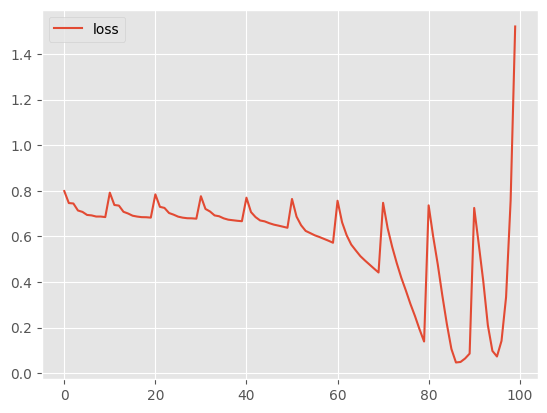

In [ ]:

style.use("ggplot")

sns.lineplot({
    "loss" : losses,

})

plt.plot()

In [26]:
def plot_matrix_values(matrix: torch.Tensor):
    # Get the indices where the matrix has values greater than zero (since zero should be ignored in size/color)
    positions = torch.nonzero(matrix >= 0, as_tuple=False)

    # Extract the x and y coordinates and the values at those positions
    x_coords = positions[:, 1]  # Column indices (horizontal axis)
    y_coords = positions[:, 0]  # Row indices (vertical axis)
    values = matrix[y_coords, x_coords]  # The values at these positions

    # Scale marker size based on values; for better visibility, multiply values by a scale factor
    marker_size = values * 200  # Scale factor (adjust as needed)

    # Normalize values to range [0, 1] for color fading
    normalized_values = (values - values.min()) / (values.max() - values.min())

    # Create a scatter plot using seaborn, with size and color based on the values
    plt.figure(figsize=(matrix.size(0)//2 , matrix.size(1)//2 ))
    scatter = sns.scatterplot(x=x_coords, y=y_coords,
                              size=values, sizes=(5_000, 0),  # Size based on values
                              hue=normalized_values, c="b", marker='o', legend=False,
                              alpha=0.3 )  # Color fading for low values
    scatter = sns.scatterplot(x=x_coords, y=y_coords,
                              size=values, sizes=(100, 0),  # Size based on values
                               c="k", marker='o', legend=False,
                              # alpha=0.3
                              )
    # Set axis limits and labels
    plt.xlim(-0.5, matrix.size(1) - 0.5)
    plt.ylim(-0.5, matrix.size(0) - 0.5)
    plt.gca().invert_yaxis()  # Invert y-axis to match matrix layout
    # plt.xlabel('X Position')
    # plt.ylabel('Y Position')
    # plt.axis("off")
    # plt.title('Area Coverage')
    # Add a colorbar to show the value mapping
    # plt.colorbar(scatter.collections[0], label='Value')
    plt.grid(True)
    plt.show()


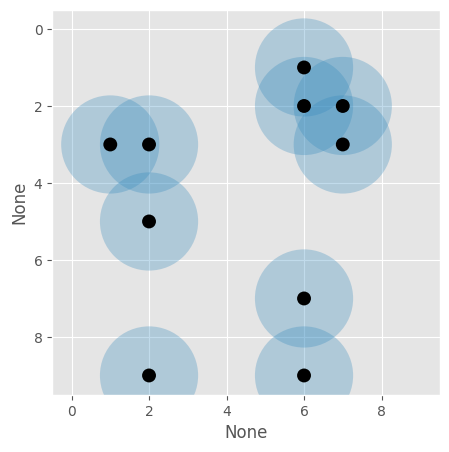

In [27]:
plot_matrix_values(env.squeeze(0). detach())


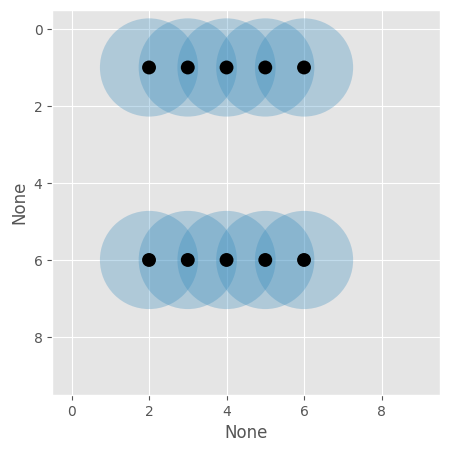

In [32]:
# print(new_state.unique(return_counts=True))
# for new_state in runs_states:
s = rearrange_sensors(new_state, num_sensor)
plot_matrix_values(s.squeeze(0). detach())